In [10]:
###### from pyspark.sql import SparkSession  
import numpy as np  
from pyspark.sql import SparkSession
spark.stop()
# Initialize Spark session with the configurations  
spark = SparkSession.builder \
    .appName("Cluster-Based SVD Regression") \
    .master("spark://spark-master:7077") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "1g") \
    .config("spark.default.parallelism", "4") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

In [11]:
#Final CODE PARALLEL
import numpy as np
from numpy.linalg import eigh
import pyspark
from pyspark import SparkContext
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix

 
def Gramiam(mat:pyspark.mllib.linalg.distributed.BlockMatrix):
    """
    Compute the inverse of a symmetric positive-definite Gramian matrix using eigenvalue decomposition.

    Args:
        gram_mat (BlockMatrix): The input Gramian matrix to invert.
        chunks (int): Block size for the resulting matrices. Default is 12.

    Returns:
        BlockMatrix: The inverse of the input Gramian matrix.
    """
    return mat.transpose().multiply(mat)


def create_block_matrix_from_numpy(np_array, block_row_size, block_col_size, spark_context):
    """
    Create a BlockMatrix from a NumPy array.
    
    Args:
        np_array (np.ndarray): The NumPy array to be converted to a BlockMatrix.
        block_row_size (int): Number of rows in each block.
        block_col_size (int): Number of columns in each block.
        spark_context (SparkContext): The Spark context used to parallelize the blocks.
        
    Returns:
        BlockMatrix: The resulting BlockMatrix.
    """
    
    # Get the shape of the numpy array
    num_rows, num_cols = np_array.shape
    
    # List to hold the blocks in the format ((blockRowIndex, blockColIndex), denseMatrix)
    blocks = []
    
    # Divide the array into blocks of block_row_size x block_col_size
    for i in range(0, num_rows, block_row_size):
        for j in range(0, num_cols, block_col_size):
            # Extract the block as a NumPy subarray
            block = np_array[i:i + block_row_size, j:j + block_col_size]
            
            # Convert the block to a DenseMatrix
            block_dense_matrix = Matrices.dense(block.shape[0], block.shape[1], block.flatten())
            
            # Store the block with its block indices (i // block_row_size, j // block_col_size)
            blocks.append(((i // block_row_size, j // block_col_size), block_dense_matrix))
    
    # Parallelize the blocks to create an RDD
    blocks_rdd = spark_context.parallelize(blocks)
    
    # Create and return the BlockMatrix
    block_matrix = BlockMatrix(blocks_rdd, block_row_size, block_col_size)
    
    return block_matrix
 
def svd(gram_mat:pyspark.mllib.linalg.distributed.BlockMatrix,chunks=12):
    """
    Perform Singular Value Decomposition (SVD) on a Gramian matrix.
    
    Args:
        gram_mat (BlockMatrix): The input Gramian matrix.
        chunks (int): Block size for the resulting matrices. Default is 12.
    
    Returns:
        tuple[BlockMatrix, BlockMatrix, BlockMatrix]: The U, Sigma-inverse, and V^T matrices as BlockMatrices.
    """
    
    arr = gram_mat.toLocalMatrix().toArray()
    eigval_V, eigvecs = np.linalg.eigh(arr)
        # Sort eigenvalues and eigenvectors in descending order
    idx = eigval_V.argsort()[::-1]
    eigval_V = eigval_V[idx]
    eigvecs = eigvecs[:, idx]
    # Compute eigenvalues
    #print("eigval_V",eigval_V)

    #print("eigvecs",eigvecs)

    tol = 1e-15
    eigvals_inv = np.array([1/val if val > tol else 0 for val in eigval_V])
    eigvals_inv = np.diag(eigvals_inv)

    #print("eigvals_inv",eigvals_inv)

    block_s_inv = create_block_matrix_from_numpy(eigvals_inv,chunks,chunks,spark.sparkContext)
    block_v= create_block_matrix_from_numpy(eigvecs,chunks,chunks,spark.sparkContext)
    block_v = block_v.transpose() # needs to be transposed for V as Result not VT

    #print("block_v",block_v.toLocalMatrix().toArray())
    #print("block_s_inv",block_s_inv.toLocalMatrix().toArray())
    #print("block_v.transpose()",block_v.transpose().toLocalMatrix().toArray())

    #print("block_v.multiply(block_s_inv).multiply(block_v.transpose())",block_v.multiply(block_s_inv).multiply(block_v.transpose()).toLocalMatrix().toArray())

    
    
    return block_v.multiply(block_s_inv).multiply(block_v.transpose())

def betacalc(X, Y):
    """
    Calculate the beta values for the input matrices X and Y.
    
    Args:
        X (BlockMatrix): The input feature matrix.
        Y (BlockMatrix): The target values matrix.
    
    Returns:
        np.ndarray: The computed beta values.
    """
    XtX = X.transpose().multiply(X)
    #print("XtX",XtX.toLocalMatrix().toArray())
    
    # Step 4: Compute beta = (X^T X)^(-1) X^T Y
    XtX_inv = svd(XtX)
    #print("XtX_inv",XtX_inv.toLocalMatrix().toArray())


    Y = Y.toLocalMatrix().toArray()
    X = X.toLocalMatrix().toArray()
    XtX_inv = XtX_inv.toLocalMatrix().toArray()

    beta = XtX_inv @ X.T @ Y

    
    return beta


In [12]:
import numpy as np
import time

# Funktion zur Erstellung einer zufälligen Matrix und Y-Vektor
def create_random_matrix_and_vector(n_rows, n_cols):
    # Zufällige Matrix X und Y erstellen
    X = Matrices.dense(n_rows, n_cols, np.random.rand(n_rows * n_cols).tolist())
    Y = Matrices.dense(n_rows, 1, np.random.rand(n_rows).tolist())
    
    # RDD für BlockMatrix erstellen
    X_blocks = sc.parallelize([((0, 0), X)])
    Y_blocks = sc.parallelize([((0, 0), Y)])
    
    matX = BlockMatrix(X_blocks, n_rows, n_cols) # Konstantenspalte ergänzen
    matY = BlockMatrix(Y_blocks, n_rows, 1)
    
    return matX, matY
sc = spark.sparkContext
#n_features_list = [10, 50, 100, 500, 1000]
n_features_list = [2, 5, 10, 20]
n_rows = max(n_features_list) * 30
elapsed_times = []
avg_elapsed_times = []
n_times = 10

for n_features in n_features_list:
    matX, matY = create_random_matrix_and_vector(n_rows, n_features)
    
    # Zeitmessung
    elapsed_time = 0
    for a in range(n_times):
        start_time = time.time()
        beta = betacalc(matX, matY)
        elapsed_time = elapsed_time + (time.time() - start_time)
        
    avg_elapsed_time = elapsed_time / n_times 
    elapsed_times.append(elapsed_time)
    avg_elapsed_times.append(avg_elapsed_time)
    print(f"Features: {n_features}, Zeit: {elapsed_time:.5f} Sekunden")
    print(f"Features: {n_features}, Zeit: {avg_elapsed_time:.5f} Sekunden")




Features: 2, Zeit: 136.53697 Sekunden
Features: 2, Zeit: 13.65370 Sekunden


Features: 5, Zeit: 115.58969 Sekunden
Features: 5, Zeit: 11.55897 Sekunden


Features: 10, Zeit: 118.45047 Sekunden
Features: 10, Zeit: 11.84505 Sekunden


Features: 20, Zeit: 111.32825 Sekunden
Features: 20, Zeit: 11.13282 Sekunden


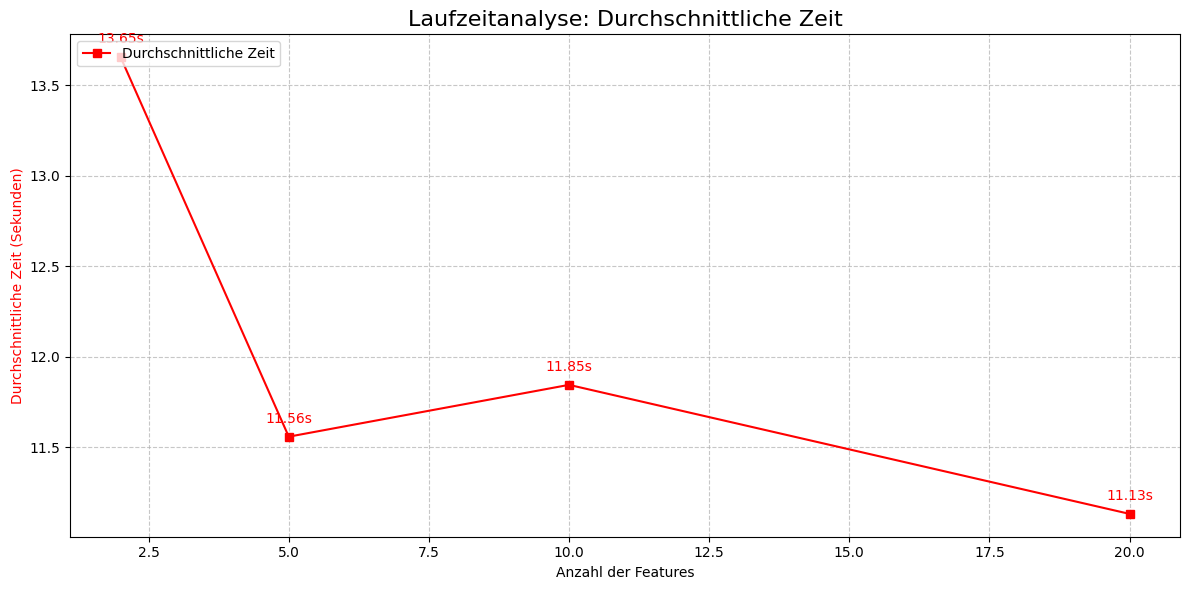

In [15]:
import matplotlib.pyplot as plt

fig2, ax2 = plt.subplots(figsize=(12, 6))
line2 = ax2.plot(n_features_list, avg_elapsed_times, 'r-', marker='s', label='Durchschnittliche Zeit')

ax2.set_xlabel('Anzahl der Features')
ax2.set_ylabel('Durchschnittliche Zeit (Sekunden)', color='r')

plt.title('Laufzeitanalyse: Durchschnittliche Zeit', fontsize=16)

ax2.legend(loc='upper left')

ax2.grid(True, linestyle='--', alpha=0.7)

for x, y in zip(n_features_list, avg_elapsed_times):
    ax2.annotate(f'{y:.2f}s', (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='r')

plt.tight_layout()

plt.show()